<a href="https://colab.research.google.com/github/SofiaRguez1020/Topicos_Industria_I/blob/main/TI_1_Practica3_Sofia_Rodriguez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 3

**Nombre:** Sofia Daniela Rodriguez Saenz

**e-mail:** sofia.rodriguez5540@alumnos.udg.mx

## MODULES

In [208]:
import math
import numpy as np
import pandas as pd

import plotly.graph_objects as go

from scipy.stats import wrapcauchy
from scipy.stats import cauchy
from scipy.stats import levy_stable

from scipy.spatial import distance

In [209]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## CLASSES

In [210]:
################# http://www.pygame.org/wiki/2DVectorClass ##################
class Vec2d(object):
    """2d vector class, supports vector and scalar operators,
       and also provides a bunch of high level functions
       """
    __slots__ = ['x', 'y']

    def __init__(self, x_or_pair, y = None):
        if y == None:
            self.x = x_or_pair[0]
            self.y = x_or_pair[1]
        else:
            self.x = x_or_pair
            self.y = y

    # Addition
    def __add__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x + other.x, self.y + other.y)
        elif hasattr(other, "__getitem__"):
            return Vec2d(self.x + other[0], self.y + other[1])
        else:
            return Vec2d(self.x + other, self.y + other)

    # Subtraction
    def __sub__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x - other.x, self.y - other.y)
        elif (hasattr(other, "__getitem__")):
            return Vec2d(self.x - other[0], self.y - other[1])
        else:
            return Vec2d(self.x - other, self.y - other)

    # Vector length
    def get_length(self):
        return math.sqrt(self.x**2 + self.y**2)

    # rotate vector
    def rotated(self, angle):
        cos = math.cos(angle)
        sin = math.sin(angle)
        x = self.x*cos - self.y*sin
        y = self.x*sin + self.y*cos
        return Vec2d(x, y)

## FUNCTIONS

In [211]:
###############################################################################################
# Brownian Motion
# This function generates a BM walk
###############################################################################################
def bm_2d(n_steps=1000, speed=5, s_pos=[0,0]):
  """
  Arguments:
    n_steps: number of steps the Brownian Trajectory will take -> int
    speed: speed of the trajectory or step size -> int
    s_pos: initial position -> [x,y] list
  Returns:
    BM_2d_df: DataFrame with x,y points of the full trajectory
  """

  # Init velocity vector
  velocity = Vec2d(speed, 0)

  BM_2d_df = pd.DataFrame(columns = ['x_pos', 'y_pos'])
  temp_df = pd.DataFrame([{'x_pos': s_pos[0], 'y_pos': s_pos[1]}])

  BM_2d_df = pd.concat([BM_2d_df, temp_df], ignore_index=True)

  for i in range(n_steps-1):
    turn_angle = np.random.uniform(low=-np.pi, high=np.pi)
    velocity = velocity.rotated(turn_angle)

    temp_df = pd.DataFrame([{'x_pos': BM_2d_df.x_pos[i]+velocity.x, 'y_pos': BM_2d_df.y_pos[i]+velocity.y}])

    BM_2d_df = pd.concat([BM_2d_df, temp_df], ignore_index=True)

  return BM_2d_df

In [212]:
###############################################################################################
# Correlated Random Walk
# This function generates a CRW Walk
###############################################################################################
def crw(n_steps=1000, speed=5, s_pos=[0,0], CRW_exponent = 0.5):
  """
  Arguments:
    n_steps: number of steps the Brownian Trajectory will take -> int
    speed: speed of the trajectory or step size -> int
    s_pos: initial position -> [x,y] list
  Returns:
    CRW_df: DataFrame with x,y points of the full trajectory
  """
  #Init DFs
  CRW_df = pd.DataFrame(columns=['x_pos', 'y_pos'])
  temp_df = pd.DataFrame([{'x_pos': s_pos[0], 'y_pos': s_pos[1]}])
  CRW_df = pd.concat([CRW_df, temp_df], ignore_index=True)

  # Init velocity vector
  velocity = Vec2d(speed,0)

  for i in range(n_steps-1):
    # Select turn angle
    turn_angle = wrapcauchy.rvs(c=CRW_exponent)
    #
    velocity = velocity.rotated(turn_angle)
    #Update position
    temp_df = pd.DataFrame([{'x_pos': CRW_df.x_pos[i]+velocity.x, 'y_pos': CRW_df.y_pos[i]+velocity.y}])
    CRW_df = pd.concat ([CRW_df,temp_df], ignore_index=True)
  return CRW_df

In [213]:
#######################################################################################################
# Euclidean distance
# This function estimates euclidean distance between two points
#######################################################################################################
def euclidean_distance(q, p):
  a2 = (q[0] - p[0])**2
  b2 = (q[1] - p[1])**2
  c = math.sqrt(a2+b2)
  return c

#######################################################################################################
# Path length calculation
# This function estimates the total path length based on euclidean distance between consecutive steps
#######################################################################################################
def path_length(trajectory):
  """
  Arguments:
    trajectory: Data set containing complete trajectory
  Returns:
    distance: calculated euclidean distance between 2 points
  """
  dis_aux = []
  for i in range (1,trajectory.shape[0]):
    dis_aux.append(euclidean_distance(trajectory.iloc[i-1], trajectory.iloc[i]))
  return pd.DataFrame(np.cumsum(dis_aux), columns=['PL'])


In [214]:
#######################################################################################################
# Mean Squared Displacement
# This function estimates the MSD
#######################################################################################################
def msd(trajectory, n=50):
  """
  Arguments:
    trajectory: Data set containing complete trajectory
    n: Window size
  Returns:
    msd_df: calculated mean squared
  """
  displacement_vec = np.array([euclidean_distance(trajectory.iloc[i-n], trajectory.iloc[i])**2 for i in range(n, trajectory.shape[0],1)])
  msd_df = pd.DataFrame(np.cumsum(displacement_vec)/(trajectory.shape[0] - n), columns=['MSD'])
  return msd_df


In [215]:
###############################################################################################
# Turning angle
# This function calculates the turning angle between three consecutive positions
###############################################################################################
def turning_angle(pos_a, pos_b, pos_c):
    """
    Arguments:
        pos_a: First position coordinates
        pos_b: Second position coordinates
        pos_c: Third position coordinates
    Returns:
        theta: Turning angle
    """
    vec_ab = np.array([pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]])
    norm_ab = np.linalg.norm(vec_ab)

    vec_bc = np.array([pos_c[0] - pos_b[0], pos_c[1] - pos_b[1]])
    norm_bc = np.linalg.norm(vec_bc)

    dot_p = np.dot(vec_ab, vec_bc)

    # Nota: Evitar division por cero con np.finfo(float).eps
    cos_theta = dot_p / (norm_ab * norm_bc + np.finfo(float).eps)

    # Angle orientation
    cross_p = np.cross(vec_ab, vec_bc)
    orient = np.sign(cross_p)
    if orient == 0:
        orient = 1

    theta = np.arccos(np.around(cos_theta,4)) * orient
    return theta


In [216]:
print(turning_angle([2,2],[5,6],[7,2]))

-2.0344287356224164


In [218]:
###############################################################################################
# Turning angles for a given trajectory
# This function calculates the all turning angles between consecutive positions in a trajectory
###############################################################################################

def ta_cal(trajectory):
  aux_ta = np.empty(shape=(0))
  # Iterate over trajectory compute turning angles
  for index, row in trajectory[1:-1].iterrows():
      aux_ta = np.append(aux_ta,turning_angle(trajectory.iloc[index-1],trajectory.iloc[index], trajectory.iloc[index+1]))
  TA_df = pd.DataFrame(aux_ta, columns=['TA'])
  return TA_df


In [219]:
###############################################################################################
# Step length
# This function calculates the step length between consecutive points
###############################################################################################

def step_length(trajectory):
  step_aux = np.array([euclidean_distance(trajectory.iloc[i], trajectory.iloc[i+1]) for i in range(trajectory.shape[0]-1)])
  SL_df = pd.DataFrame(step_aux, columns=['SL'])
  return SL_df

In [363]:
###############################################################################################
# Levy walk
# This function generates a levy Walk
###############################################################################################
def levy_flight(n_steps=1000, init_speed = 5, s_pos=[0,0], CRW_exponent = 0.5, alpha = 1.5, beta = 0, loc=3.0):
  #Init DFs
  Levy_df = pd.DataFrame(columns=['x_pos', 'y_pos'])
  temp_df = pd.DataFrame([{'x_pos': s_pos[0], 'y_pos': s_pos[1]}])
  Levy_df = pd.concat([Levy_df, temp_df], ignore_index=True)

  # Init velocity vector
  velocity = Vec2d(init_speed,0)

  for i in range(n_steps-1):
    # Select turn angle
    turn_angle = wrapcauchy.rvs(c=CRW_exponent)
    #step size
    step_size = levy_stable.rvs(alpha=alpha, beta=beta, loc=loc)

    velocity = velocity.rotated(turn_angle)
    #Update position
    temp_df = pd.DataFrame([{'x_pos': Levy_df.x_pos[i]+(velocity.x*step_size), 'y_pos': Levy_df.y_pos[i]+(velocity.y*step_size)}])
    Levy_df = pd.concat ([Levy_df,temp_df], ignore_index=True)
  return Levy_df

## Actividad 1: Path Length - (BM1 vs BM2 vs CRW) (4 pts)

* Implementar función que genere **Brownian Motions** (BM) utilizando **pandas**.
* Implementar función que genere **Correlated Random Walks** (CRW) utilizando pandas.
* Implementar una función alternativa a las ya disponibles en los distintos modulos de python que calcule los valores de la curva de **path length** de una trayectoria.
* Guardar los valores de la métrica en un Data Frame de **pandas**.
* Visualizar con **plotly**.

In [220]:
# Load existing trajectories to test your implementation
# BM speed = 3
BM_2d_df_3 = pd.read_csv('drive/MyDrive/Files_colab/brownian_3.csv')

# Load existing trajectories to test your implementation
# BM speed = 6
BM_2d_df_6 = pd.read_csv('drive/MyDrive/Files_colab/brownian_6.csv')

# Load existing trajectories to test your implementation
CRW_2d_df_9 = pd.read_csv('drive/MyDrive/Files_colab/crw_6_9.csv')

In [221]:
# Define your function to compute path length for given trajectory
#  *****************See Function section for fuction implementation *********************

In [222]:
# Get Path length calling the function
PL_BM_3 = path_length(BM_2d_df_3)# Add your code here function(BM_2d_df_3)

# Get Path length calling the function
PL_BM_6 = path_length(BM_2d_df_6)# Add your code here function(BM_2d_df_6)

# Get Path length calling the function
PL_CRW_6 = path_length(CRW_2d_df_9)# Add your code here function(CRW_2d_df_9)

In [223]:
PL_BM_3.head()

,PL
0,3.0
1,6.0
2,9.0
3,12.0
4,15.0


In [224]:
# Plotting
# Init figure
fig_path_length = go.Figure()

# First trace BM1
fig_path_length.add_trace(go.Scatter(
    x = np.arange(len(PL_BM_3.PL))+1,
    y = PL_BM_3.PL,
    name = 'path_length_BM_3',
    showlegend = True
))

# First trace BM6
fig_path_length.add_trace(go.Scatter(
    x = np.arange(len(PL_BM_6.PL))+1,
    y = PL_BM_6.PL,
    name = 'path_length_BM_6',
    line = dict(width = 5),
    showlegend = True
))

# Third trace CRW
fig_path_length.add_trace(go.Scatter(
    x = np.arange(len(PL_CRW_6.PL))+1,
    y = PL_BM_6.PL,
    name = 'path_length_CRW_6',
    showlegend = True
))
fig_path_length.show()

## Actividad 2: Mean Squared Displacement - (Brownian vs CRW) (4 pts)

* Generar una trayectoria tipo **BM** y una **CRW**.
* Implementar una función que calcule los valores de la curva de **mean squared displacement** de una trayectoria.
* Guardar metricas en Pandas Data Frame.
* Visualizar con **plotly**.

In [225]:
# Load existing trajectories to test your implementation
# BM speed = 6
BM_2d_df_6 = pd.read_csv('drive/MyDrive/Files_colab/brownian_6.csv')

# Load existing trajectories to test your implementation
# CRW speed = 6, c = 0.9
CRW_2d_df_9 = pd.read_csv('drive/MyDrive/Files_colab/crw_6_9.csv')

In [226]:
# Show trajectories
# Init figure
fig_3d = go.Figure()

# Plot trajectory in 3-D space
fig_3d.add_trace(
    go.Scatter3d(x = BM_2d_df_6.x_pos,
                 y = BM_2d_df_6.y_pos,
                 z = BM_2d_df_6.index,
                 marker = dict(size=2),
                 line = dict(color='blue', width=2),
                 mode = 'lines',
                 name = 'BM 2d',
                 showlegend = True))


fig_3d.add_trace(
    go.Scatter3d(x = CRW_2d_df_9.x_pos,
                 y = CRW_2d_df_9.y_pos,
                 z = CRW_2d_df_9.index,
                 marker = dict(size=2),
                 line = dict(color='red', width=2),
                 mode = 'lines',
                 name = 'CRW 2d',
                 showlegend = True))

fig_3d.show()

In [227]:
# Define your function to compute Mean Squared Displacement for given trajectory

#  ***************** See Function section for fuction implementation *********************

In [228]:
# Get Mean Squared Displacement calling the function
MSD_BM = msd(BM_2d_df_6, 500)# Add your code here function(BM_2d_df_6)

# Get Mean Squared Displacement calling the function
MSD_CRW = msd(CRW_2d_df_9, 500)# Add your code here function(CRW_2d_df_9)

In [229]:
MSD_BM.head()

,MSD
0,44.943471
1,84.729914
2,130.486832
3,174.947588
4,219.198777


In [230]:
# Init figure
fig_MSD = go.Figure()

# first trace MSD_BM
fig_MSD.add_trace(go.Scatter(
                 x = MSD_BM.index,
                 y = MSD_BM.MSD,
                 name = 'MSD BW 6',
                 showlegend = True
                 ))


# Second trace MSD_CRW
fig_MSD.add_trace(go.Scatter(
                 x = MSD_CRW.index,
                 y = MSD_CRW.MSD,
                 line = dict(width = 4),
                 name = 'MSD CRW 6',
                 showlegend = True
                 ))

fig_MSD.show()

## Actividad 3: Turning-angle Distribution - (Dist. origen vs Dist. observada) (6 pts)

* Generar **CRWs** con dos exponentes diferentes
* Guardar trayectorias en **Pandas** Data Frame
* Implementar una función que calcule los valores de **turning angle** de una trayectoria.
* Comparar en gráfica distribución origen vs distribución observada (Histograma)
* Visualizar con **plotly**

In [231]:
# Load existing trajectories to test your implementation
# CRW speed = 6,
# wrapcauchy [c = 0.6]
CRW_2d_df_6 = pd.read_csv('drive/MyDrive/Files_colab/crw_6_6.csv')

# Load existing trajectories to test your implementation
# CRW speed = 6,
# wrapcauchy [c = 0.9]
CRW_2d_df_9 = pd.read_csv('drive/MyDrive/Files_colab/crw_6_9.csv')

In [232]:
# Define your function to compute Turning Angles for given trajectory

#  ***************** See Function section for fuction implementation *********************

In [233]:
# Get Turning Angles calling the function
ta_CRW_2d_df_6 = ta_cal(CRW_2d_df_6)# Add your code here function(CRW_2d_df_6)

# Get Turning Angles calling the function
ta_CRW_2d_df_9 = ta_cal(CRW_2d_df_9)# Add your code here function(CRW_2d_df_9)

In [234]:
ta_CRW_2d_df_6.head(10)

,TA
0,1.526081
1,-1.995115
2,1.248337
3,0.478471
4,-0.547363
5,-0.020000
6,-0.123366
7,-0.474109
8,-1.358915
9,-2.981421


In [235]:
ta_CRW_2d_df_9.head(10)

,TA
0,0.131243
1,-0.116685
2,0.310765
3,-0.086050
4,1.131171
5,0.020000
6,-0.535723
7,-0.034643
8,-0.014142
9,-0.040003


In [347]:
# Check documentation
# https://plotly.com/python/histograms/

# PLot histogram
fig_met_df_3 = go.Figure()

# Histogram turning angle CRW_2d_df_6
fig_met_df_3.add_trace(go.Histogram(
                 x=ta_CRW_2d_df_6.TA,
                 name = 'observed 0.6',
                 showlegend = True,
                 xbins=dict(size=0.03),
                 histnorm='probability density'
                 ))


# Histogram turning angle CRW_2d_df_9
fig_met_df_3.add_trace(go.Histogram(
                 x=ta_CRW_2d_df_9.TA,
                 name = 'observed 0.9',
                 showlegend = True,
                 xbins=dict(size=0.03),
                 histnorm='probability density'
                 ))


# Add origin distributions
aux_domain = np.linspace(-3, 3, 1000)

out1 = cauchy.fit(ta_CRW_2d_df_6.TA)
y1 = cauchy.pdf(aux_domain, *out1)

fig_met_df_3.add_trace(go.Scatter(
                 x=aux_domain,
                 y= y1,
                 name = 'cauchy_0.6',
                 showlegend = True,
                 line=dict(color='blue')
                 ))

out2 = cauchy.fit(ta_CRW_2d_df_9.TA)
y2 = cauchy.pdf(aux_domain, *out2)

fig_met_df_3.add_trace(go.Scatter(
                 x=aux_domain,
                 y= y2,
                 name = 'cauchy_0.9',
                 showlegend = True,
                 line=dict(color='red')
                 ))


fig_met_df_3.show()

In [348]:
out1

(-0.04617916490184331, 0.46708821243861187)

## Actividad 4: Step-length Distribution - (Dist. origen vs Dist. observada) (6 pts)

* Implementar función que genere **Lévy Walks** (LW) utilizando pandas.
* Guardar trayectorias en Pandas Data Frame.
* Implementar una función que calcule los valores de **step lenght** de una trayectoria.
* Guardar trayectorias en **pandas** Data Frame.
* Obtener **Step-length** distribution.
* Comparar en gráfica distribución origen vs distribución observada (Histograma).
* Visualizar con plotly.

In [364]:
# Load existing trajectories to test your implementation
# Levy speed = 6
# levy_stable [alpha=1.0, beta=1.0, loc=3.0]
Levy_2d_df_1 = levy_flight(init_speed = 6, n_steps=1000,alpha=1.0, beta=1.0, loc=3.0)#pd.read_csv('drive/MyDrive/Files_colab/levy_6_1.csv')#

# Load existing trajectories to test your implementation
# Levy speed = 6
# levy_stable [alpha=0.7, beta=1.0, loc=3.0]
Levy_2d_df_7 = levy_flight(init_speed = 6, n_steps=1000,alpha=0.7, beta=1.0, loc=3.0)#pd.read_csv('drive/MyDrive/Files_colab/levy_6_7.csv')

In [238]:
# Define your function to compute Step lengths for given trajectory

#  ***************** See Function section for fuction implementation *********************

In [365]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=Levy_2d_df_1.x_pos,
                          y=Levy_2d_df_1.y_pos,
                          marker=dict(size=2),
                          line=dict(width=2),
                          mode='lines',
                          name='levy_1',
                          showlegend=True))

fig.add_trace(go.Scatter(x=Levy_2d_df_7.x_pos,
                          y=Levy_2d_df_7.y_pos,
                          marker=dict(size=2),
                          line=dict(width=2),
                          mode='lines',
                          name='levy_7',
                          showlegend=True))
fig.show()

In [366]:

# Get Step lengths calling the function
sl_Levy_2d_df_1 = step_length(Levy_2d_df_1)# Add your code here function(Levy_2d_df_1)

# Get Step lengths calling the function
sl_Levy_2d_df_7 = step_length(Levy_2d_df_7)# Add your code here function(Levy_2d_df_7)

In [278]:
sl_Levy_2d_df_1.tail()

,SL
9994,4.5
9995,1.0
9996,3.0
9997,10.0
9998,3.0


In [279]:
print(distance.euclidean([2,5],[-3.654784419,2.994155248]))

5.999999999540926


In [390]:
# PLot histogram
fig_met_df_4 = go.Figure()

# Histogram step-length Levy_2d_df_1
# Histogram turning angle CRW_2d_df_6
fig_met_df_4.add_trace(go.Histogram(
                 x=sl_Levy_2d_df_1.SL,
                 name = 'Observed_alpha=1.0_beta=1.0',
                 showlegend = True,
                 histnorm='probability',
                 xbins=dict(size=4)
                 ))

# Histogram step-length Levy_2d_df_7
fig_met_df_4.add_trace(go.Histogram(
                 x=sl_Levy_2d_df_7.SL,
                 name = 'Observed_alpha=0.7_beta=1.0',
                 showlegend = True,
                 histnorm='probability'
                 ))


# Add origin distributions
x = np.linspace(0, 200, 1000)
loc = np.min(sl_Levy_2d_df_1.SL)
y1 = levy_stable.pdf(x, alpha=1.0, beta=1.0, loc=loc)
fig_met_df_4.add_trace(go.Scatter(
                 x= x,
                 y= y1,
                 name = 'cauchy_0.6',
                 showlegend = True,
                 line=dict(color='blue')
                 ))

loc = np.min(sl_Levy_2d_df_7.SL)
y2 = levy_stable.pdf(x, alpha=0.7, beta=1.0, loc=loc)
fig_met_df_4.add_trace(go.Scatter(
                 x= x,
                 y= y2,
                 name = 'cauchy_0.6',
                 showlegend = True,
                 line=dict(color='red')
                 ))


fig_met_df_4.update_layout(xaxis=dict(range=[0, 250]))

fig_met_df_4.show()

In [360]:

from scipy.stats import levy


In [336]:
out


(5.672127581949157, 12.26340243983001)

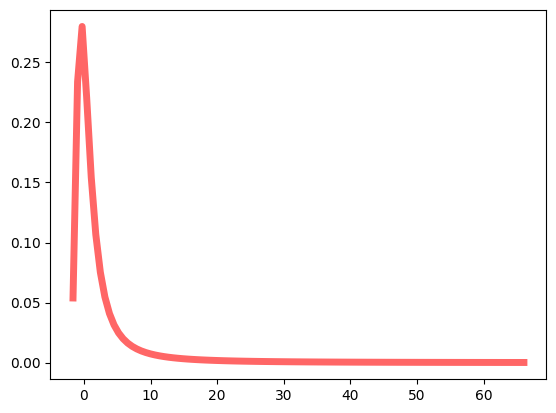

In [196]:
import numpy as np
from scipy.stats import levy_stable
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
alpha, beta = 1.0, 1.0
mean, var, skew, kurt = levy_stable.stats(alpha, beta, moments='mvsk')

x = np.linspace(levy_stable.ppf(0.01, alpha, beta),
                levy_stable.ppf(0.99, alpha, beta), 100)
ax.plot(x, levy_stable.pdf(x, alpha, beta),
       'r-', lw=5, alpha=0.6, label='levy_stable pdf')